# Some take-ways from this notebook

Greedy strategy can be perfectly and easily approximated by a neural network;
However, greedy strategy itself is sub-optimal compared to Dijkstra; the 
algorithm can easily be stuck in a cycle, leading to bad results.

One thing that is a bit concerning is that the graph is small; the network
tends to memorize the entire graph; some experiments on much bigger graphs
should be conducted to verify that the network is actually learning something
useful.

It would be very interesting to see to what extent can Dijkstra be approximated.

# Validate on new graphs

A model that is trained on one random graph
should and indeed can be used to infer paths
on another random graph. This, to some extent,
proves that the network has gained some knowledge,
which is good news.
In this case, the knowledge is the greedy strategy,
i.e., always go with the edge that has the smallest
weight.

In [1149]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [1150]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [733]:
def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.DiGraph()
    G.add_nodes_from(range(0, node_size))
    
    for node in G.nodes:
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        random.shuffle(tmp_nodes)
        
        out_neighbors = tmp_nodes[:random.randint(min_out_degree, max_out_degree)]
        
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for out_neighbor in out_neighbors:
            G.add_edge(node, out_neighbor, weight=random.uniform(weight_min, weight_max))
        
    return G

def generate_rand_weighted_g(node_size=NUM_NODE, p=0.02, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [874]:
G = generate_rand_weighted_g(node_size=NUM_NODE, p=0.06)
print(G.number_of_nodes())
print(G.number_of_edges())
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

100
609


12

In [1095]:
G = generate_low_degree_g()
print(G.number_of_nodes())
print(G.number_of_edges())

20
60


In [1096]:
nx.find_cycle(G)

[(17, 8), (8, 18), (18, 10), (10, 17)]

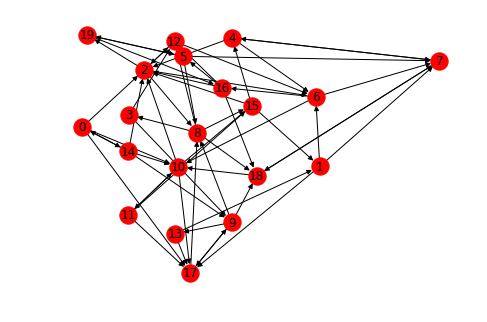

In [1097]:
nx.draw(G, with_labels=True)
plt.show()

In [1098]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

4

In [920]:
def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones(max_out_degree)

        for idx, out_edge in enumerate(G.out_edges(node)):
            init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])
        assert label == init_weight_vec[np.argmin(init_weight_vec)]
        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)

In [921]:
print(features.shape)
print(labels.shape)

(20, 4)
(20,)


In [922]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
            
    return np.array(X_aug), np.array(y_aug)

def augment_dataset_extend_features(X, y=None, augmentation_index=10):
    pass

In [924]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=100)
print(X_aug.shape)
print(y_aug.shape)

(2000, 4)
(2000, 4)


In [925]:
print(X_aug[0])
print(y_aug[0])

[ 0.25297004  0.30496655  0.62963934  0.08270936]
[ 0.  0.  0.  1.]


In [926]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(2000, 4)
(2000, 4)


In [927]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 4)
(1800, 4)
(200, 4)
(200, 4)


In [1116]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [1122]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [1123]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [1124]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [1125]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=1000)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Train-custom_acc=0.343333
INFO:root:Epoch[0] Time cost=0.007
INFO:root:Epoch[0] Validation-custom_acc=0.570000
INFO:root:Epoch[1] Batch [10]	Speed: 69486.99 samples/sec	custom_acc=0.479091
INFO:root:Epoch[1] Train-custom_acc=0.620000
INFO:root:Epoch[1] Time cost=0.029
INFO:root:Epoch[1] Validation-custom_acc=0.600000
INFO:root:Epoch[2] Batch [10]	Speed: 72196.09 samples/sec	custom_acc=0.724545
INFO:root:Epoch[2] Train-custom_acc=0.862857
INFO:root:Epoch[2] Time cost=0.028
INFO:root:Epoch[2] Validation-custom_acc=0.875000
INFO:root:Epoch[3] Batch [10]	Speed: 71484.88 samples/sec	custom_acc=0.914545
INFO:root:Epoch[3] Train-custom_acc=0.948571
INFO:root:Epoch[3] Time cost=0.029
INFO:root:Epoch[3] Validation-custom_acc=0.915000
INFO:root:Epoch[4] Batch [10]	Speed: 107560.05 samples/sec	custom_acc=0.953636
INFO:root:Epoch[4] Train-custom_acc=0.964286
INFO:root:Epoch[4] Time cost=0.021
INFO:root:Epoch[4] Validation-custom_acc=0.945000
INFO:root:Epoch[5] Batch [10]	Speed: 

INFO:root:Epoch[39] Batch [10]	Speed: 105173.12 samples/sec	custom_acc=0.990909
INFO:root:Epoch[39] Train-custom_acc=0.980000
INFO:root:Epoch[39] Time cost=0.023
INFO:root:Epoch[39] Validation-custom_acc=0.970000
INFO:root:Epoch[40] Batch [10]	Speed: 74594.58 samples/sec	custom_acc=0.990909
INFO:root:Epoch[40] Train-custom_acc=0.980000
INFO:root:Epoch[40] Time cost=0.027
INFO:root:Epoch[40] Validation-custom_acc=0.970000
INFO:root:Epoch[41] Batch [10]	Speed: 108753.70 samples/sec	custom_acc=0.990909
INFO:root:Epoch[41] Train-custom_acc=0.980000
INFO:root:Epoch[41] Time cost=0.022
INFO:root:Epoch[41] Validation-custom_acc=0.975000
INFO:root:Epoch[42] Batch [10]	Speed: 100512.93 samples/sec	custom_acc=0.990909
INFO:root:Epoch[42] Train-custom_acc=0.980000
INFO:root:Epoch[42] Time cost=0.023
INFO:root:Epoch[42] Validation-custom_acc=0.975000
INFO:root:Epoch[43] Batch [10]	Speed: 107260.23 samples/sec	custom_acc=0.990909
INFO:root:Epoch[43] Train-custom_acc=0.980000
INFO:root:Epoch[43] Tim

INFO:root:Epoch[77] Time cost=0.023
INFO:root:Epoch[77] Validation-custom_acc=0.980000
INFO:root:Epoch[78] Batch [10]	Speed: 93702.34 samples/sec	custom_acc=0.994545
INFO:root:Epoch[78] Train-custom_acc=0.985714
INFO:root:Epoch[78] Time cost=0.028
INFO:root:Epoch[78] Validation-custom_acc=0.980000
INFO:root:Epoch[79] Batch [10]	Speed: 96423.00 samples/sec	custom_acc=0.994545
INFO:root:Epoch[79] Train-custom_acc=0.985714
INFO:root:Epoch[79] Time cost=0.024
INFO:root:Epoch[79] Validation-custom_acc=0.980000
INFO:root:Epoch[80] Batch [10]	Speed: 96618.46 samples/sec	custom_acc=0.994545
INFO:root:Epoch[80] Train-custom_acc=0.985714
INFO:root:Epoch[80] Time cost=0.027
INFO:root:Epoch[80] Validation-custom_acc=0.980000
INFO:root:Epoch[81] Batch [10]	Speed: 94030.04 samples/sec	custom_acc=0.994545
INFO:root:Epoch[81] Train-custom_acc=0.987143
INFO:root:Epoch[81] Time cost=0.024
INFO:root:Epoch[81] Validation-custom_acc=0.980000
INFO:root:Epoch[82] Batch [10]	Speed: 92524.13 samples/sec	custom

INFO:root:Epoch[116] Batch [10]	Speed: 98492.52 samples/sec	custom_acc=0.994545
INFO:root:Epoch[116] Train-custom_acc=0.985714
INFO:root:Epoch[116] Time cost=0.022
INFO:root:Epoch[116] Validation-custom_acc=0.985000
INFO:root:Epoch[117] Batch [10]	Speed: 81766.69 samples/sec	custom_acc=0.994545
INFO:root:Epoch[117] Train-custom_acc=0.985714
INFO:root:Epoch[117] Time cost=0.024
INFO:root:Epoch[117] Validation-custom_acc=0.990000
INFO:root:Epoch[118] Batch [10]	Speed: 97780.72 samples/sec	custom_acc=0.994545
INFO:root:Epoch[118] Train-custom_acc=0.985714
INFO:root:Epoch[118] Time cost=0.023
INFO:root:Epoch[118] Validation-custom_acc=0.990000
INFO:root:Epoch[119] Batch [10]	Speed: 94831.54 samples/sec	custom_acc=0.994545
INFO:root:Epoch[119] Train-custom_acc=0.985714
INFO:root:Epoch[119] Time cost=0.022
INFO:root:Epoch[119] Validation-custom_acc=0.990000
INFO:root:Epoch[120] Batch [10]	Speed: 93756.80 samples/sec	custom_acc=0.994545
INFO:root:Epoch[120] Train-custom_acc=0.985714
INFO:root

INFO:root:Epoch[154] Batch [10]	Speed: 98775.50 samples/sec	custom_acc=0.995455
INFO:root:Epoch[154] Train-custom_acc=0.988571
INFO:root:Epoch[154] Time cost=0.025
INFO:root:Epoch[154] Validation-custom_acc=0.990000
INFO:root:Epoch[155] Batch [10]	Speed: 98754.57 samples/sec	custom_acc=0.995455
INFO:root:Epoch[155] Train-custom_acc=0.988571
INFO:root:Epoch[155] Time cost=0.023
INFO:root:Epoch[155] Validation-custom_acc=0.990000
INFO:root:Epoch[156] Batch [10]	Speed: 101123.61 samples/sec	custom_acc=0.995455
INFO:root:Epoch[156] Train-custom_acc=0.988571
INFO:root:Epoch[156] Time cost=0.022
INFO:root:Epoch[156] Validation-custom_acc=0.990000
INFO:root:Epoch[157] Batch [10]	Speed: 105262.86 samples/sec	custom_acc=0.995455
INFO:root:Epoch[157] Train-custom_acc=0.988571
INFO:root:Epoch[157] Time cost=0.022
INFO:root:Epoch[157] Validation-custom_acc=0.990000
INFO:root:Epoch[158] Batch [10]	Speed: 90595.59 samples/sec	custom_acc=0.995455
INFO:root:Epoch[158] Train-custom_acc=0.988571
INFO:ro

INFO:root:Epoch[192] Batch [10]	Speed: 107631.81 samples/sec	custom_acc=0.995455
INFO:root:Epoch[192] Train-custom_acc=0.987143
INFO:root:Epoch[192] Time cost=0.022
INFO:root:Epoch[192] Validation-custom_acc=0.990000
INFO:root:Epoch[193] Batch [10]	Speed: 109566.21 samples/sec	custom_acc=0.995455
INFO:root:Epoch[193] Train-custom_acc=0.987143
INFO:root:Epoch[193] Time cost=0.022
INFO:root:Epoch[193] Validation-custom_acc=0.990000
INFO:root:Epoch[194] Batch [10]	Speed: 106619.49 samples/sec	custom_acc=0.995455
INFO:root:Epoch[194] Train-custom_acc=0.987143
INFO:root:Epoch[194] Time cost=0.022
INFO:root:Epoch[194] Validation-custom_acc=0.990000
INFO:root:Epoch[195] Batch [10]	Speed: 100836.74 samples/sec	custom_acc=0.995455
INFO:root:Epoch[195] Train-custom_acc=0.987143
INFO:root:Epoch[195] Time cost=0.023
INFO:root:Epoch[195] Validation-custom_acc=0.990000
INFO:root:Epoch[196] Batch [10]	Speed: 110644.30 samples/sec	custom_acc=0.995455
INFO:root:Epoch[196] Train-custom_acc=0.987143
INFO

INFO:root:Epoch[230] Batch [10]	Speed: 51629.19 samples/sec	custom_acc=0.994545
INFO:root:Epoch[230] Train-custom_acc=0.988571
INFO:root:Epoch[230] Time cost=0.040
INFO:root:Epoch[230] Validation-custom_acc=0.990000
INFO:root:Epoch[231] Batch [10]	Speed: 61816.39 samples/sec	custom_acc=0.994545
INFO:root:Epoch[231] Train-custom_acc=0.988571
INFO:root:Epoch[231] Time cost=0.036
INFO:root:Epoch[231] Validation-custom_acc=0.990000
INFO:root:Epoch[232] Batch [10]	Speed: 62984.16 samples/sec	custom_acc=0.995455
INFO:root:Epoch[232] Train-custom_acc=0.988571
INFO:root:Epoch[232] Time cost=0.037
INFO:root:Epoch[232] Validation-custom_acc=0.990000
INFO:root:Epoch[233] Batch [10]	Speed: 71865.81 samples/sec	custom_acc=0.995455
INFO:root:Epoch[233] Train-custom_acc=0.987143
INFO:root:Epoch[233] Time cost=0.029
INFO:root:Epoch[233] Validation-custom_acc=0.990000
INFO:root:Epoch[234] Batch [10]	Speed: 109195.39 samples/sec	custom_acc=0.995455
INFO:root:Epoch[234] Train-custom_acc=0.987143
INFO:roo

INFO:root:Epoch[268] Batch [10]	Speed: 32212.34 samples/sec	custom_acc=0.996364
INFO:root:Epoch[268] Train-custom_acc=0.991429
INFO:root:Epoch[268] Time cost=0.076
INFO:root:Epoch[268] Validation-custom_acc=1.000000
INFO:root:Epoch[269] Batch [10]	Speed: 31010.57 samples/sec	custom_acc=0.996364
INFO:root:Epoch[269] Train-custom_acc=0.991429
INFO:root:Epoch[269] Time cost=0.060
INFO:root:Epoch[269] Validation-custom_acc=1.000000
INFO:root:Epoch[270] Batch [10]	Speed: 53780.71 samples/sec	custom_acc=0.996364
INFO:root:Epoch[270] Train-custom_acc=0.991429
INFO:root:Epoch[270] Time cost=0.038
INFO:root:Epoch[270] Validation-custom_acc=1.000000
INFO:root:Epoch[271] Batch [10]	Speed: 55664.29 samples/sec	custom_acc=0.996364
INFO:root:Epoch[271] Train-custom_acc=0.991429
INFO:root:Epoch[271] Time cost=0.037
INFO:root:Epoch[271] Validation-custom_acc=1.000000
INFO:root:Epoch[272] Batch [10]	Speed: 55667.24 samples/sec	custom_acc=0.996364
INFO:root:Epoch[272] Train-custom_acc=0.991429
INFO:root

INFO:root:Epoch[306] Batch [10]	Speed: 74355.23 samples/sec	custom_acc=0.997273
INFO:root:Epoch[306] Train-custom_acc=0.991429
INFO:root:Epoch[306] Time cost=0.031
INFO:root:Epoch[306] Validation-custom_acc=1.000000
INFO:root:Epoch[307] Batch [10]	Speed: 68591.54 samples/sec	custom_acc=0.997273
INFO:root:Epoch[307] Train-custom_acc=0.991429
INFO:root:Epoch[307] Time cost=0.038
INFO:root:Epoch[307] Validation-custom_acc=1.000000
INFO:root:Epoch[308] Batch [10]	Speed: 69209.51 samples/sec	custom_acc=0.997273
INFO:root:Epoch[308] Train-custom_acc=0.991429
INFO:root:Epoch[308] Time cost=0.035
INFO:root:Epoch[308] Validation-custom_acc=1.000000
INFO:root:Epoch[309] Batch [10]	Speed: 107723.03 samples/sec	custom_acc=0.997273
INFO:root:Epoch[309] Train-custom_acc=0.991429
INFO:root:Epoch[309] Time cost=0.023
INFO:root:Epoch[309] Validation-custom_acc=1.000000
INFO:root:Epoch[310] Batch [10]	Speed: 102185.45 samples/sec	custom_acc=0.997273
INFO:root:Epoch[310] Train-custom_acc=0.991429
INFO:ro

INFO:root:Epoch[344] Batch [10]	Speed: 63738.38 samples/sec	custom_acc=0.997273
INFO:root:Epoch[344] Train-custom_acc=0.991429
INFO:root:Epoch[344] Time cost=0.036
INFO:root:Epoch[344] Validation-custom_acc=1.000000
INFO:root:Epoch[345] Batch [10]	Speed: 60676.21 samples/sec	custom_acc=0.997273
INFO:root:Epoch[345] Train-custom_acc=0.991429
INFO:root:Epoch[345] Time cost=0.034
INFO:root:Epoch[345] Validation-custom_acc=1.000000
INFO:root:Epoch[346] Batch [10]	Speed: 65496.09 samples/sec	custom_acc=0.997273
INFO:root:Epoch[346] Train-custom_acc=0.991429
INFO:root:Epoch[346] Time cost=0.035
INFO:root:Epoch[346] Validation-custom_acc=1.000000
INFO:root:Epoch[347] Batch [10]	Speed: 61701.81 samples/sec	custom_acc=0.997273
INFO:root:Epoch[347] Train-custom_acc=0.991429
INFO:root:Epoch[347] Time cost=0.038
INFO:root:Epoch[347] Validation-custom_acc=1.000000
INFO:root:Epoch[348] Batch [10]	Speed: 70891.64 samples/sec	custom_acc=0.997273
INFO:root:Epoch[348] Train-custom_acc=0.991429
INFO:root

INFO:root:Epoch[382] Batch [10]	Speed: 34618.75 samples/sec	custom_acc=0.998182
INFO:root:Epoch[382] Train-custom_acc=0.992857
INFO:root:Epoch[382] Time cost=0.053
INFO:root:Epoch[382] Validation-custom_acc=1.000000
INFO:root:Epoch[383] Batch [10]	Speed: 44222.26 samples/sec	custom_acc=0.999091
INFO:root:Epoch[383] Train-custom_acc=0.992857
INFO:root:Epoch[383] Time cost=0.048
INFO:root:Epoch[383] Validation-custom_acc=1.000000
INFO:root:Epoch[384] Batch [10]	Speed: 45144.70 samples/sec	custom_acc=0.998182
INFO:root:Epoch[384] Train-custom_acc=0.992857
INFO:root:Epoch[384] Time cost=0.045
INFO:root:Epoch[384] Validation-custom_acc=1.000000
INFO:root:Epoch[385] Batch [10]	Speed: 45417.48 samples/sec	custom_acc=0.998182
INFO:root:Epoch[385] Train-custom_acc=0.992857
INFO:root:Epoch[385] Time cost=0.046
INFO:root:Epoch[385] Validation-custom_acc=1.000000
INFO:root:Epoch[386] Batch [10]	Speed: 45363.93 samples/sec	custom_acc=0.999091
INFO:root:Epoch[386] Train-custom_acc=0.992857
INFO:root

INFO:root:Epoch[420] Batch [10]	Speed: 93650.03 samples/sec	custom_acc=0.999091
INFO:root:Epoch[420] Train-custom_acc=0.994286
INFO:root:Epoch[420] Time cost=0.023
INFO:root:Epoch[420] Validation-custom_acc=1.000000
INFO:root:Epoch[421] Batch [10]	Speed: 61383.95 samples/sec	custom_acc=0.999091
INFO:root:Epoch[421] Train-custom_acc=0.994286
INFO:root:Epoch[421] Time cost=0.035
INFO:root:Epoch[421] Validation-custom_acc=1.000000
INFO:root:Epoch[422] Batch [10]	Speed: 51706.21 samples/sec	custom_acc=0.999091
INFO:root:Epoch[422] Train-custom_acc=0.994286
INFO:root:Epoch[422] Time cost=0.041
INFO:root:Epoch[422] Validation-custom_acc=1.000000
INFO:root:Epoch[423] Batch [10]	Speed: 39742.50 samples/sec	custom_acc=0.999091
INFO:root:Epoch[423] Train-custom_acc=0.994286
INFO:root:Epoch[423] Time cost=0.051
INFO:root:Epoch[423] Validation-custom_acc=1.000000
INFO:root:Epoch[424] Batch [10]	Speed: 43641.12 samples/sec	custom_acc=0.999091
INFO:root:Epoch[424] Train-custom_acc=0.994286
INFO:root

INFO:root:Epoch[458] Batch [10]	Speed: 37522.18 samples/sec	custom_acc=0.999091
INFO:root:Epoch[458] Train-custom_acc=0.994286
INFO:root:Epoch[458] Time cost=0.053
INFO:root:Epoch[458] Validation-custom_acc=1.000000
INFO:root:Epoch[459] Batch [10]	Speed: 40582.71 samples/sec	custom_acc=0.999091
INFO:root:Epoch[459] Train-custom_acc=0.994286
INFO:root:Epoch[459] Time cost=0.054
INFO:root:Epoch[459] Validation-custom_acc=1.000000
INFO:root:Epoch[460] Batch [10]	Speed: 52145.91 samples/sec	custom_acc=0.999091
INFO:root:Epoch[460] Train-custom_acc=0.994286
INFO:root:Epoch[460] Time cost=0.044
INFO:root:Epoch[460] Validation-custom_acc=1.000000
INFO:root:Epoch[461] Batch [10]	Speed: 61778.15 samples/sec	custom_acc=0.999091
INFO:root:Epoch[461] Train-custom_acc=0.994286
INFO:root:Epoch[461] Time cost=0.035
INFO:root:Epoch[461] Validation-custom_acc=1.000000
INFO:root:Epoch[462] Batch [10]	Speed: 68152.41 samples/sec	custom_acc=0.999091
INFO:root:Epoch[462] Train-custom_acc=0.994286
INFO:root

INFO:root:Epoch[496] Batch [10]	Speed: 66698.00 samples/sec	custom_acc=0.999091
INFO:root:Epoch[496] Train-custom_acc=0.995714
INFO:root:Epoch[496] Time cost=0.034
INFO:root:Epoch[496] Validation-custom_acc=1.000000
INFO:root:Epoch[497] Batch [10]	Speed: 67258.45 samples/sec	custom_acc=0.999091
INFO:root:Epoch[497] Train-custom_acc=0.995714
INFO:root:Epoch[497] Time cost=0.034
INFO:root:Epoch[497] Validation-custom_acc=1.000000
INFO:root:Epoch[498] Batch [10]	Speed: 68263.33 samples/sec	custom_acc=0.999091
INFO:root:Epoch[498] Train-custom_acc=0.995714
INFO:root:Epoch[498] Time cost=0.033
INFO:root:Epoch[498] Validation-custom_acc=1.000000
INFO:root:Epoch[499] Batch [10]	Speed: 62987.94 samples/sec	custom_acc=0.999091
INFO:root:Epoch[499] Train-custom_acc=0.995714
INFO:root:Epoch[499] Time cost=0.036
INFO:root:Epoch[499] Validation-custom_acc=1.000000
INFO:root:Epoch[500] Batch [10]	Speed: 69788.75 samples/sec	custom_acc=0.999091
INFO:root:Epoch[500] Train-custom_acc=0.995714
INFO:root

INFO:root:Epoch[534] Batch [10]	Speed: 110828.48 samples/sec	custom_acc=1.000000
INFO:root:Epoch[534] Train-custom_acc=0.997143
INFO:root:Epoch[534] Time cost=0.022
INFO:root:Epoch[534] Validation-custom_acc=1.000000
INFO:root:Epoch[535] Batch [10]	Speed: 105141.48 samples/sec	custom_acc=1.000000
INFO:root:Epoch[535] Train-custom_acc=0.997143
INFO:root:Epoch[535] Time cost=0.023
INFO:root:Epoch[535] Validation-custom_acc=1.000000
INFO:root:Epoch[536] Batch [10]	Speed: 102542.70 samples/sec	custom_acc=1.000000
INFO:root:Epoch[536] Train-custom_acc=0.997143
INFO:root:Epoch[536] Time cost=0.023
INFO:root:Epoch[536] Validation-custom_acc=1.000000
INFO:root:Epoch[537] Batch [10]	Speed: 62944.46 samples/sec	custom_acc=1.000000
INFO:root:Epoch[537] Train-custom_acc=0.997143
INFO:root:Epoch[537] Time cost=0.040
INFO:root:Epoch[537] Validation-custom_acc=1.000000
INFO:root:Epoch[538] Batch [10]	Speed: 63775.21 samples/sec	custom_acc=1.000000
INFO:root:Epoch[538] Train-custom_acc=0.997143
INFO:r

INFO:root:Epoch[572] Batch [10]	Speed: 96190.81 samples/sec	custom_acc=1.000000
INFO:root:Epoch[572] Train-custom_acc=0.997143
INFO:root:Epoch[572] Time cost=0.024
INFO:root:Epoch[572] Validation-custom_acc=1.000000
INFO:root:Epoch[573] Batch [10]	Speed: 103550.28 samples/sec	custom_acc=1.000000
INFO:root:Epoch[573] Train-custom_acc=0.997143
INFO:root:Epoch[573] Time cost=0.023
INFO:root:Epoch[573] Validation-custom_acc=1.000000
INFO:root:Epoch[574] Batch [10]	Speed: 101265.22 samples/sec	custom_acc=1.000000
INFO:root:Epoch[574] Train-custom_acc=0.997143
INFO:root:Epoch[574] Time cost=0.022
INFO:root:Epoch[574] Validation-custom_acc=1.000000
INFO:root:Epoch[575] Batch [10]	Speed: 99483.03 samples/sec	custom_acc=1.000000
INFO:root:Epoch[575] Train-custom_acc=0.997143
INFO:root:Epoch[575] Time cost=0.023
INFO:root:Epoch[575] Validation-custom_acc=1.000000
INFO:root:Epoch[576] Batch [10]	Speed: 99691.11 samples/sec	custom_acc=1.000000
INFO:root:Epoch[576] Train-custom_acc=0.997143
INFO:ro

INFO:root:Epoch[610] Batch [10]	Speed: 99691.11 samples/sec	custom_acc=1.000000
INFO:root:Epoch[610] Train-custom_acc=0.997143
INFO:root:Epoch[610] Time cost=0.022
INFO:root:Epoch[610] Validation-custom_acc=1.000000
INFO:root:Epoch[611] Batch [10]	Speed: 101813.38 samples/sec	custom_acc=1.000000
INFO:root:Epoch[611] Train-custom_acc=0.997143
INFO:root:Epoch[611] Time cost=0.022
INFO:root:Epoch[611] Validation-custom_acc=1.000000
INFO:root:Epoch[612] Batch [10]	Speed: 104645.69 samples/sec	custom_acc=1.000000
INFO:root:Epoch[612] Train-custom_acc=0.997143
INFO:root:Epoch[612] Time cost=0.022
INFO:root:Epoch[612] Validation-custom_acc=1.000000
INFO:root:Epoch[613] Batch [10]	Speed: 98657.01 samples/sec	custom_acc=1.000000
INFO:root:Epoch[613] Train-custom_acc=0.997143
INFO:root:Epoch[613] Time cost=0.024
INFO:root:Epoch[613] Validation-custom_acc=1.000000
INFO:root:Epoch[614] Batch [10]	Speed: 101749.16 samples/sec	custom_acc=1.000000
INFO:root:Epoch[614] Train-custom_acc=0.997143
INFO:r

INFO:root:Epoch[648] Batch [10]	Speed: 58778.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[648] Train-custom_acc=0.997143
INFO:root:Epoch[648] Time cost=0.036
INFO:root:Epoch[648] Validation-custom_acc=1.000000
INFO:root:Epoch[649] Batch [10]	Speed: 98541.11 samples/sec	custom_acc=1.000000
INFO:root:Epoch[649] Train-custom_acc=0.997143
INFO:root:Epoch[649] Time cost=0.024
INFO:root:Epoch[649] Validation-custom_acc=1.000000
INFO:root:Epoch[650] Batch [10]	Speed: 77616.24 samples/sec	custom_acc=1.000000
INFO:root:Epoch[650] Train-custom_acc=0.997143
INFO:root:Epoch[650] Time cost=0.024
INFO:root:Epoch[650] Validation-custom_acc=1.000000
INFO:root:Epoch[651] Batch [10]	Speed: 97011.77 samples/sec	custom_acc=1.000000
INFO:root:Epoch[651] Train-custom_acc=0.997143
INFO:root:Epoch[651] Time cost=0.021
INFO:root:Epoch[651] Validation-custom_acc=1.000000
INFO:root:Epoch[652] Batch [10]	Speed: 109864.68 samples/sec	custom_acc=1.000000
INFO:root:Epoch[652] Train-custom_acc=0.997143
INFO:roo

INFO:root:Epoch[686] Batch [10]	Speed: 114233.30 samples/sec	custom_acc=1.000000
INFO:root:Epoch[686] Train-custom_acc=0.997143
INFO:root:Epoch[686] Time cost=0.021
INFO:root:Epoch[686] Validation-custom_acc=0.990000
INFO:root:Epoch[687] Batch [10]	Speed: 106359.93 samples/sec	custom_acc=1.000000
INFO:root:Epoch[687] Train-custom_acc=0.997143
INFO:root:Epoch[687] Time cost=0.022
INFO:root:Epoch[687] Validation-custom_acc=0.990000
INFO:root:Epoch[688] Batch [10]	Speed: 102975.72 samples/sec	custom_acc=1.000000
INFO:root:Epoch[688] Train-custom_acc=0.997143
INFO:root:Epoch[688] Time cost=0.023
INFO:root:Epoch[688] Validation-custom_acc=0.990000
INFO:root:Epoch[689] Batch [10]	Speed: 99344.01 samples/sec	custom_acc=1.000000
INFO:root:Epoch[689] Train-custom_acc=0.997143
INFO:root:Epoch[689] Time cost=0.023
INFO:root:Epoch[689] Validation-custom_acc=0.990000
INFO:root:Epoch[690] Batch [10]	Speed: 100248.67 samples/sec	custom_acc=1.000000
INFO:root:Epoch[690] Train-custom_acc=0.997143
INFO:

INFO:root:Epoch[724] Batch [10]	Speed: 105954.23 samples/sec	custom_acc=1.000000
INFO:root:Epoch[724] Train-custom_acc=0.997143
INFO:root:Epoch[724] Time cost=0.022
INFO:root:Epoch[724] Validation-custom_acc=0.990000
INFO:root:Epoch[725] Batch [10]	Speed: 105887.35 samples/sec	custom_acc=1.000000
INFO:root:Epoch[725] Train-custom_acc=0.997143
INFO:root:Epoch[725] Time cost=0.023
INFO:root:Epoch[725] Validation-custom_acc=0.990000
INFO:root:Epoch[726] Batch [10]	Speed: 113325.88 samples/sec	custom_acc=1.000000
INFO:root:Epoch[726] Train-custom_acc=0.997143
INFO:root:Epoch[726] Time cost=0.024
INFO:root:Epoch[726] Validation-custom_acc=0.990000
INFO:root:Epoch[727] Batch [10]	Speed: 113069.25 samples/sec	custom_acc=1.000000
INFO:root:Epoch[727] Train-custom_acc=0.997143
INFO:root:Epoch[727] Time cost=0.024
INFO:root:Epoch[727] Validation-custom_acc=0.990000
INFO:root:Epoch[728] Batch [10]	Speed: 113301.39 samples/sec	custom_acc=1.000000
INFO:root:Epoch[728] Train-custom_acc=0.997143
INFO

INFO:root:Epoch[762] Batch [10]	Speed: 101306.80 samples/sec	custom_acc=1.000000
INFO:root:Epoch[762] Train-custom_acc=0.998571
INFO:root:Epoch[762] Time cost=0.022
INFO:root:Epoch[762] Validation-custom_acc=0.990000
INFO:root:Epoch[763] Batch [10]	Speed: 86714.71 samples/sec	custom_acc=1.000000
INFO:root:Epoch[763] Train-custom_acc=0.998571
INFO:root:Epoch[763] Time cost=0.024
INFO:root:Epoch[763] Validation-custom_acc=0.990000
INFO:root:Epoch[764] Batch [10]	Speed: 98561.96 samples/sec	custom_acc=1.000000
INFO:root:Epoch[764] Train-custom_acc=0.998571
INFO:root:Epoch[764] Time cost=0.023
INFO:root:Epoch[764] Validation-custom_acc=0.990000
INFO:root:Epoch[765] Batch [10]	Speed: 95463.95 samples/sec	custom_acc=1.000000
INFO:root:Epoch[765] Train-custom_acc=0.998571
INFO:root:Epoch[765] Time cost=0.023
INFO:root:Epoch[765] Validation-custom_acc=0.990000
INFO:root:Epoch[766] Batch [10]	Speed: 92626.30 samples/sec	custom_acc=1.000000
INFO:root:Epoch[766] Train-custom_acc=0.998571
INFO:roo

INFO:root:Epoch[800] Batch [10]	Speed: 102628.01 samples/sec	custom_acc=1.000000
INFO:root:Epoch[800] Train-custom_acc=0.998571
INFO:root:Epoch[800] Time cost=0.023
INFO:root:Epoch[800] Validation-custom_acc=0.990000
INFO:root:Epoch[801] Batch [10]	Speed: 96879.57 samples/sec	custom_acc=1.000000
INFO:root:Epoch[801] Train-custom_acc=0.998571
INFO:root:Epoch[801] Time cost=0.028
INFO:root:Epoch[801] Validation-custom_acc=0.990000
INFO:root:Epoch[802] Batch [10]	Speed: 112941.38 samples/sec	custom_acc=1.000000
INFO:root:Epoch[802] Train-custom_acc=0.998571
INFO:root:Epoch[802] Time cost=0.024
INFO:root:Epoch[802] Validation-custom_acc=0.990000
INFO:root:Epoch[803] Batch [10]	Speed: 103496.62 samples/sec	custom_acc=1.000000
INFO:root:Epoch[803] Train-custom_acc=0.998571
INFO:root:Epoch[803] Time cost=0.024
INFO:root:Epoch[803] Validation-custom_acc=0.990000
INFO:root:Epoch[804] Batch [10]	Speed: 103338.52 samples/sec	custom_acc=1.000000
INFO:root:Epoch[804] Train-custom_acc=0.998571
INFO:

INFO:root:Epoch[838] Batch [10]	Speed: 67705.76 samples/sec	custom_acc=1.000000
INFO:root:Epoch[838] Train-custom_acc=0.998571
INFO:root:Epoch[838] Time cost=0.032
INFO:root:Epoch[838] Validation-custom_acc=0.990000
INFO:root:Epoch[839] Batch [10]	Speed: 80056.19 samples/sec	custom_acc=1.000000
INFO:root:Epoch[839] Train-custom_acc=0.998571
INFO:root:Epoch[839] Time cost=0.031
INFO:root:Epoch[839] Validation-custom_acc=0.990000
INFO:root:Epoch[840] Batch [10]	Speed: 106654.73 samples/sec	custom_acc=1.000000
INFO:root:Epoch[840] Train-custom_acc=0.998571
INFO:root:Epoch[840] Time cost=0.022
INFO:root:Epoch[840] Validation-custom_acc=0.990000
INFO:root:Epoch[841] Batch [10]	Speed: 103425.16 samples/sec	custom_acc=1.000000
INFO:root:Epoch[841] Train-custom_acc=0.998571
INFO:root:Epoch[841] Time cost=0.022
INFO:root:Epoch[841] Validation-custom_acc=0.990000
INFO:root:Epoch[842] Batch [10]	Speed: 102658.15 samples/sec	custom_acc=1.000000
INFO:root:Epoch[842] Train-custom_acc=0.998571
INFO:r

INFO:root:Epoch[876] Batch [10]	Speed: 106021.18 samples/sec	custom_acc=1.000000
INFO:root:Epoch[876] Train-custom_acc=1.000000
INFO:root:Epoch[876] Time cost=0.022
INFO:root:Epoch[876] Validation-custom_acc=0.990000
INFO:root:Epoch[877] Batch [10]	Speed: 98204.26 samples/sec	custom_acc=1.000000
INFO:root:Epoch[877] Train-custom_acc=1.000000
INFO:root:Epoch[877] Time cost=0.023
INFO:root:Epoch[877] Validation-custom_acc=0.990000
INFO:root:Epoch[878] Batch [10]	Speed: 102607.92 samples/sec	custom_acc=1.000000
INFO:root:Epoch[878] Train-custom_acc=1.000000
INFO:root:Epoch[878] Time cost=0.022
INFO:root:Epoch[878] Validation-custom_acc=0.990000
INFO:root:Epoch[879] Batch [10]	Speed: 102839.38 samples/sec	custom_acc=1.000000
INFO:root:Epoch[879] Train-custom_acc=1.000000
INFO:root:Epoch[879] Time cost=0.024
INFO:root:Epoch[879] Validation-custom_acc=0.990000
INFO:root:Epoch[880] Batch [10]	Speed: 100645.58 samples/sec	custom_acc=1.000000
INFO:root:Epoch[880] Train-custom_acc=1.000000
INFO:

INFO:root:Epoch[914] Batch [10]	Speed: 108979.76 samples/sec	custom_acc=1.000000
INFO:root:Epoch[914] Train-custom_acc=1.000000
INFO:root:Epoch[914] Time cost=0.022
INFO:root:Epoch[914] Validation-custom_acc=0.990000
INFO:root:Epoch[915] Batch [10]	Speed: 110682.25 samples/sec	custom_acc=1.000000
INFO:root:Epoch[915] Train-custom_acc=1.000000
INFO:root:Epoch[915] Time cost=0.021
INFO:root:Epoch[915] Validation-custom_acc=0.990000
INFO:root:Epoch[916] Batch [10]	Speed: 95777.86 samples/sec	custom_acc=1.000000
INFO:root:Epoch[916] Train-custom_acc=1.000000
INFO:root:Epoch[916] Time cost=0.023
INFO:root:Epoch[916] Validation-custom_acc=0.990000
INFO:root:Epoch[917] Batch [10]	Speed: 99384.02 samples/sec	custom_acc=1.000000
INFO:root:Epoch[917] Train-custom_acc=1.000000
INFO:root:Epoch[917] Time cost=0.023
INFO:root:Epoch[917] Validation-custom_acc=0.990000
INFO:root:Epoch[918] Batch [10]	Speed: 107537.98 samples/sec	custom_acc=1.000000
INFO:root:Epoch[918] Train-custom_acc=1.000000
INFO:r

INFO:root:Epoch[952] Batch [10]	Speed: 60081.71 samples/sec	custom_acc=1.000000
INFO:root:Epoch[952] Train-custom_acc=1.000000
INFO:root:Epoch[952] Time cost=0.033
INFO:root:Epoch[952] Validation-custom_acc=0.990000
INFO:root:Epoch[953] Batch [10]	Speed: 59551.96 samples/sec	custom_acc=1.000000
INFO:root:Epoch[953] Train-custom_acc=1.000000
INFO:root:Epoch[953] Time cost=0.036
INFO:root:Epoch[953] Validation-custom_acc=0.990000
INFO:root:Epoch[954] Batch [10]	Speed: 100411.86 samples/sec	custom_acc=1.000000
INFO:root:Epoch[954] Train-custom_acc=1.000000
INFO:root:Epoch[954] Time cost=0.022
INFO:root:Epoch[954] Validation-custom_acc=0.990000
INFO:root:Epoch[955] Batch [10]	Speed: 69166.14 samples/sec	custom_acc=1.000000
INFO:root:Epoch[955] Train-custom_acc=1.000000
INFO:root:Epoch[955] Time cost=0.028
INFO:root:Epoch[955] Validation-custom_acc=0.990000
INFO:root:Epoch[956] Batch [10]	Speed: 76022.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[956] Train-custom_acc=1.000000
INFO:roo

INFO:root:Epoch[990] Batch [10]	Speed: 63500.03 samples/sec	custom_acc=1.000000
INFO:root:Epoch[990] Train-custom_acc=1.000000
INFO:root:Epoch[990] Time cost=0.043
INFO:root:Epoch[990] Validation-custom_acc=0.990000
INFO:root:Epoch[991] Batch [10]	Speed: 44587.05 samples/sec	custom_acc=1.000000
INFO:root:Epoch[991] Train-custom_acc=1.000000
INFO:root:Epoch[991] Time cost=0.050
INFO:root:Epoch[991] Validation-custom_acc=0.990000
INFO:root:Epoch[992] Batch [10]	Speed: 32281.01 samples/sec	custom_acc=1.000000
INFO:root:Epoch[992] Train-custom_acc=1.000000
INFO:root:Epoch[992] Time cost=0.059
INFO:root:Epoch[992] Validation-custom_acc=0.990000
INFO:root:Epoch[993] Batch [10]	Speed: 32854.76 samples/sec	custom_acc=1.000000
INFO:root:Epoch[993] Train-custom_acc=1.000000
INFO:root:Epoch[993] Time cost=0.052
INFO:root:Epoch[993] Validation-custom_acc=0.990000
INFO:root:Epoch[994] Batch [10]	Speed: 73518.50 samples/sec	custom_acc=1.000000
INFO:root:Epoch[994] Train-custom_acc=1.000000
INFO:root

In [1126]:
pred = np.argmax(model.predict(mx.io.NDArrayIter(X_train, y_train, batch_size=len(y_train))).asnumpy(), axis=1)
accuracy_score(np.argmax(y_train, axis=1), pred)

0.98555555555555552

In [1137]:
def infer_next_node(G, cur_node):
#     print("In infer_next_node")
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
#     print("In nn_infer_next_node")
    input_vec = np.ones(4)
    
    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        input_vec[idx] = G.get_edge_data(cur_node, out_edge[1])['weight']
    
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([input_vec]), np.array([0]))).asnumpy()[0])
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [1138]:
src, dst = 8, 7

print greedy_path_finder(G, src, dst)
print greedy_path_finder(G, src, dst, use_nn=True, model=model)

([8, 12, 2, 6, 16, 5, 7], 1.3814473290675409, True)
([8, 12, 2, 6, 16, 5, 7], 1.3814473290675409, True)


In [1131]:
nx.dijkstra_path(G, 8, 7)

[8, 15, 4, 7]

In [1139]:
def check_greedy_path_finder_acc(G, model):
    
    correct_cnt = 0
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if found == nn_found and path == nn_path:
                correct_cnt = correct_cnt + 1
            else:
                print('src %d dst %d incorrect' % (src, dst))
    
    num_nodes = G.number_of_nodes()
    return float(correct_cnt) / (num_nodes*(num_nodes-1))

In [1146]:
G_1 = generate_low_degree_g()
print(G_1.number_of_nodes())
print(G_1.number_of_edges())

20
61


In [ ]:
check_greedy_path_finder_acc(G_1, model)

src 13 dst 0 incorrect
src 13 dst 1 incorrect
src 13 dst 2 incorrect
src 13 dst 3 incorrect
src 13 dst 4 incorrect
src 13 dst 5 incorrect
src 13 dst 6 incorrect
src 13 dst 7 incorrect
src 13 dst 8 incorrect
src 13 dst 9 incorrect
src 13 dst 10 incorrect
src 13 dst 11 incorrect
src 13 dst 12 incorrect
src 13 dst 14 incorrect
src 13 dst 15 incorrect
src 13 dst 16 incorrect
src 13 dst 17 incorrect
src 13 dst 18 incorrect
src 13 dst 19 incorrect


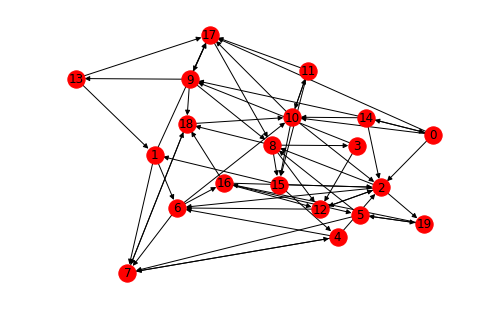

In [1115]:
nx.draw(G, with_labels=True)
plt.show()